In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98;} </style>"))

### **Overview**
A typical RAG application has two main components:

- Indexing: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

- Retrieval and generation: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

### **Indexing**
- Load: First we need to load our data. This is done with Document Loaders.
- Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
- Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

Once we've indexed our data, we will use LangGraph as our orchestration framework to implement the retrieval and generation steps.

### __Retrieval and generation__
- Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
- Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

In [10]:
#%pip install ipywidgets
#%pip install python-dotenv
#%pip install langchain
#%pip install --quiet --upgrade langchain-core langsmith langchain-text-splitters langchain-community langgraph 

### __LangSmith__

In [ ]:
from dotenv import load_dotenv
import os

# Carga las variables desde el fichero .env en el directorio actual
load_dotenv()

api_key = os.getenv("LANGSMITH_API_KEY")
if api_key:
    print("Clave de LangSmith cargada correctamente")
else:
    print("No se encontró la clave de LangSmith")

Clave de LangSmith cargada correctamente


### __Components__

#### __1. Select LLM Model__

In [12]:
#%pip install -U transformers
#%pip install -U langchain-ollama
#%pip install ollama

- Para descargar una versión local del modelo LLM hay que instalar Ollama desde: https://ollama.com/download
- Después ejecutar los siguientes comandos en powershell o cmd después de añadir Ollama al PATH del sistema:
  1. 'ollama run hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0' en una terminal que funciona como servidor.
  2. Para ver detalles del modelo: .\ollama.exe list
- Es un modelo de 3B de parámetros y 8 bits.

https://huggingface.co/bartowski/Llama-3.2-3B-Instruct-GGUF

In [8]:
from langchain_ollama import OllamaLLM
# ollama run hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0
llm = OllamaLLM(model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0") 
print(llm.invoke("Dime algo curioso sobre el imperio romano"))

El Imperio Romano fue un vasto y complejo estado que se extendió durante varias centurias, dejando una profunda huella en la historia de Europa y más allá. Uno de los aspectos más fascinantes del Imperio Romano es su sistema de "cursus honorum", que era el camino que debían seguir las personas para ascender en el rango administrativo y militar del imperio. Este cursus honorum era estructurado en varios grados y se iniciaba con cargos menores, pero con creciente responsabilidad y prestigio.

En este sistema, los nuevos candidatos al servicio público o a la carrera militar debían comenzar como "centuriones", un cargo que equivalía aproximadamente a un teniente. A medida que avanzaban en su carrera, podían promocionarse a "tribuno", luego a "gobernador" de una provincia y finalmente a magistrado romano o gobernante del imperio.

El sistema era tan riguroso que incluso los filósofos y intelectuales no estaban exentos de su influencia. Platón, por ejemplo, tuvo que servir en el ejército rom

#### __2. Select Embeddings Model__

In [14]:
#%pip install -qU langchain-huggingface
#%pip install sentence-transformers
#%pip install huggingface_hub[hf_xet]

In [3]:
# Modelo más pequeño
from langchain_huggingface import HuggingFaceEmbeddings

model_embeddings_mini = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
print("Modelo de Embeddings inicializado") 

e:\ANACONDA\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
e:\ANACONDA\envs\rag\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Modelo de Embeddings inicializado


#### __3. Select Vector Store__

In [17]:
#%pip install -qU langchain-qdrant

Primero, inicializamos Qdrant en memoria para realizar pruebas.

In [18]:
'''
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
from langchain_qdrant import QdrantVectorStore

# Inicializar Qdrant en memoria para realizar pruebas
client = QdrantClient(":memory:")

vector_store = QdrantVectorStore(
    client=client,
    collection_name="test",
    embedding=model_embeddings
)

print("Vector store creado en memoria")
'''

'\nfrom qdrant_client import QdrantClient\nfrom qdrant_client.models import VectorParams, Distance\nfrom langchain_qdrant import QdrantVectorStore\n\n# Inicializar Qdrant en memoria para realizar pruebas\nclient = QdrantClient(":memory:")\n\nvector_store = QdrantVectorStore(\n    client=client,\n    collection_name="test",\n    embedding=model_embeddings\n)\n\nprint("Vector store creado en memoria")\n'

In [5]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

COLLECTION_NAME = "idearq-allMiniLM-L6-v2"  # Nombre de la colección
VECTOR_SIZE = 384

# Inicializar cliente
client = QdrantClient(url="http://localhost:6333")

# Borrar colección (si ya existe)
if COLLECTION_NAME in [c.name for c in client.get_collections().collections]:
    client.delete_collection(COLLECTION_NAME)

# Crear colección
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

# cambio distance.dot a coseno porque es más recomendable en texto
# size a 384 porque es el tamaño de los embeddings de all-MiniLM-L6-v2

C:\Users\elevi\AppData\Local\Temp\ipykernel_26860\3817225433.py:15: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [6]:
client = QdrantClient(url="http://localhost:6333")
info = client.get_collection(COLLECTION_NAME)
assert info.config.params.vectors.size == 384, "La colección no está configurada para vectores de 384 dimensiones."
print("La dimensión de los vectores (384) es correcta")

La dimensión de los vectores (384) es correcta


Cuando convertimos texto a embeddings, lo que nos importa es el "significado" o "dirección" del texto, no cuánto "mide" el vector, por eso escogemos la similitud del coseno. Dos frases con significado similar tendrán vectores que apuntan en la misma dirección, resultando en una similitud de coseno cercana a 1.
Rango: de -1 (opuestos) a 1 (idénticos).

## __Indexing__

### __Loading__

In [20]:
# TEST DE CARGA DE PDFS
from pathlib import Path
import re
from langchain.document_loaders import PyPDFLoader, PyMuPDFLoader

pdf_dir = Path("pdf_test/")
pdf_files = list(pdf_dir.glob("*.pdf"))

results = {}

for loader_name, loader_class in {
    "PyPDFLoader": lambda path:PyPDFLoader(path, mode="single"),
    "PyMuPDFLoader": lambda path: PyMuPDFLoader(path, mode="single")
}.items():
    total_docs = 0
    total_length = 0
    for pdf_file in pdf_files:
        try:
            loader = loader_class(str(pdf_file))
            docs = loader.load()
            total_docs += len(docs)
            total_length += sum(len(doc.page_content) for doc in docs)
        except Exception as e:
            print(f"Error con {loader_name} en {pdf_file.name}: {e}")
    avg_length = total_length / total_docs if total_docs else 0
    results[loader_name] = {
        "n_docs": total_docs,
        "avg_length": round(avg_length, 2)
    }

for name, stats in results.items():
    print(f"{name}: {stats['n_docs']} documentos, longitud media {stats['avg_length']} caracteres")


PyPDFLoader: 11 documentos, longitud media 60469.36 caracteres
PyMuPDFLoader: 11 documentos, longitud media 60264.0 caracteres


In [ ]:
# TEST DE CARGA DE PDFS SIN COMPARAR PERO CON MÁS EJEMPLOS
import re
from langchain.document_loaders import PyPDFLoader, PyMuPDFLoader

folder_path = Path("pdf_test/")
pdf_files = list(folder_path.glob("*.pdf"))

# Cargar todos los PDFs
all_docs = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(str(pdf_file), mode="single") # mode="page" divide los documentos por página
    docs = loader.load()
    all_docs.extend(docs)

print(f"Se cargaron {len(all_docs)} documentos")

Se cargaron 11 documentos


In [10]:
import logging
from pathlib import Path
from langchain.document_loaders import PyMuPDFLoader

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

all_docs = []
folder_path = Path("pdf_articulos_idearq-v2/ingesta-2/")  

logging.info(f"Iniciando la carga de documentos desde: {folder_path.resolve()}")

if not folder_path.is_dir():
    logging.error(f"El directorio especificado no existe: {folder_path.resolve()}")
else:
    # Usamos .glob() que es eficiente para buscar archivos
    for pdf_file in folder_path.glob("*.pdf"):
        try:
            loader = PyMuPDFLoader(str(pdf_file), mode="single")
            docs_from_file = loader.load()
            all_docs.extend(docs_from_file)
        except Exception as e:
            # Este bloque capturará si un PDF específico está dañado y no se puede leer
            logging.warning(f"No se pudo cargar el archivo '{pdf_file.name}'. Saltando. Error: {e}")

    logging.info(f"Carga finalizada. Se han cargado un total de {len(all_docs)} documentos.")

2025-08-20 11:38:28,643 - INFO - Iniciando la carga de documentos desde: C:\Users\elevi\Documents\CSIC\RAG\pdf_articulos_idearq-v2\ingesta-2


2025-08-20 11:39:03,151 - INFO - Carga finalizada. Se han cargado un total de 128 documentos.


Me decanto por PyMuPDFLoader porque es más flexible frente a PDFs con estructuras complejas, en cambio PyPDF es demasiado estricto y no puede gestionar algunos PDFs, desembocando en errores.

### __Splitting__

https://python.langchain.com/docs/tutorials/retrievers/
https://python.langchain.com/docs/tutorials/rag/
https://qdrant.tech/documentation/quickstart/
https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import logging

# Configurar un logger para controlar el proceso
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

text_splitter_config = {
    "chunk_size": 1000,
    "chunk_overlap": 200, # 15-20% de chunk_size
    "length_function": len,
    "add_start_index": True,
    "separators": ["\n\n", "\n", ". ", " ", ""],
}

# El operador ** desempaqueta el diccionario como argumentos 
text_splitter = RecursiveCharacterTextSplitter(**text_splitter_config)

all_splits = text_splitter.split_documents(all_docs)

logging.info(f"Se dividieron {len(all_docs)} documentos en un total de {len(all_splits)} chunks")

2025-08-20 11:39:05,194 - INFO - Se dividieron 128 documentos en un total de 31190 chunks


In [ ]:
# revisar uno o dos chunks para asegurar que el splitting es lógico
if all_splits:
    logging.info("Ejemplo del primer chunk generado:")
    print(all_splits[0].page_content)
    logging.info("Metadatos del primer chunk:")
    pprint.pp(all_splits[0].metadata)


2025-07-16 12:31:41,337 - INFO - Ejemplo del primer chunk generado:
2025-07-16 12:31:41,338 - INFO - Metadatos del primer chunk:


Full Terms & Conditions of access and use can be found at
http://www.tandfonline.com/action/journalInformation?journalCode=yjfa20
Download by: [University of Newcastle, Australia]
Date: 20 February 2017, At: 04:16
Journal of Field Archaeology
ISSN: 0093-4690 (Print) 2042-4582 (Online) Journal homepage: http://www.tandfonline.com/loi/yjfa20
First Evidence of Collective Human Inhumation
from the Cardial Neolithic (Cova Bonica, Barcelona,
NE Iberian Peninsula)
F. Xavier Oms, Joan Daura, Montserrat Sanz, Susana Mendiela, Mireia Pedro
& Pablo Martínez
To cite this article: F. Xavier Oms, Joan Daura, Montserrat Sanz, Susana Mendiela, Mireia Pedro
& Pablo Martínez (2017) First Evidence of Collective Human Inhumation from the Cardial Neolithic
(Cova Bonica, Barcelona, NE Iberian Peninsula), Journal of Field Archaeology, 42:1, 43-53, DOI:
10.1080/00934690.2016.1260407
To link to this article:  http://dx.doi.org/10.1080/00934690.2016.1260407
Published online: 13 Feb 2017.
{'producer': 'iText 4.2

- RecursiveCharacterTextSplitter: Intenta mantener párrafos y frases juntas, lo cual es puede ser mejor que un corte abrupto por caracteres. Hay otro splitters pero son para código o Markdown.
- chunk_size=1000, chunk_overlap=200: El solapamiento (overlap) es crucial para no perder contexto en los límites de cada trozo de texto (chunk).
add_start_index=True: Se utiliza para depuración y para saber de qué parte del documento original proviene cada chunk.

https://python.langchain.com/docs/integrations/document_loaders/grobid/

En principio, estos parámetros son los recomendables en RAGs con modelos pequeños. Se podría subir chunk_size a 1500 si las respuestas pierden contexto, aunque un tamaño de 1000 permite respuestas más específicas.

From langchain: We set add_start_index=True so that the character index where each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

Podríamos hacer otro tipo de split, que es el split semántico: https://python.langchain.com/docs/how_to/semantic-chunker/

### __Embeddings y almacenamiento__

Primero tenemos las celdas de testeo.

In [ ]:
vector_1 = embedding.embed_query(all_splits[0].page_content)
vector_2 = embedding.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 2560

[-0.0002388065040577203, 0.06825609505176544, 0.004310491029173136, -0.00017211480007972568, -0.0008121936116367579, 0.04217046499252319, -0.03311644122004509, 0.018160805106163025, 0.001344389165751636, 0.025389451533555984]


Nos conectamos a la base de datos vectorial en Qdrant a través del cliente de Langchain y realizamos la ingesta de los chunks.

In [12]:
from langchain_qdrant import QdrantVectorStore
import logging
from langchain_core.embeddings import Embeddings 

QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "idearq-allMiniLM-L6-v2"


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = QdrantClient(url=QDRANT_URL)

logging.info(f"Conectando a la colección '{COLLECTION_NAME}' a través de LangChain...")

vector_store = QdrantVectorStore(
    client=client,
    collection_name=COLLECTION_NAME,
    embedding=model_embeddings_mini,
)
logging.info("Objeto 'vector_store' listo para la ingesta")

logging.info(f"Iniciando la ingesta de {len(all_splits)} chunks...")

vector_store.add_documents(all_splits)

logging.info("Ingesta completada")

2025-08-20 11:39:05,275 - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"


2025-08-20 11:39:05,278 - INFO - Conectando a la colección 'idearq-allMiniLM-L6-v2' a través de LangChain...
2025-08-20 11:39:05,301 - INFO - HTTP Request: GET http://localhost:6333/collections/idearq-allMiniLM-L6-v2 "HTTP/1.1 200 OK"
2025-08-20 11:39:05,323 - INFO - Objeto 'vector_store' listo para la ingesta
2025-08-20 11:39:05,325 - INFO - Iniciando la ingesta de 31190 chunks...
2025-08-20 11:39:06,174 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points?wait=true "HTTP/1.1 200 OK"
2025-08-20 11:39:06,623 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points?wait=true "HTTP/1.1 200 OK"
2025-08-20 11:39:07,062 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points?wait=true "HTTP/1.1 200 OK"
2025-08-20 11:39:07,485 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points?wait=true "HTTP/1.1 200 OK"
2025-08-20 11:39:07,940 - INFO - HTTP Reque

In [13]:
# Verficación

from qdrant_client import QdrantClient
client = QdrantClient(url="http://localhost:6333")

COLLECTION_NAME = "idearq-allMiniLM-L6-v2" 

print("\n--- Verificación en Qdrant ---")
print(f"Información de la colección '{COLLECTION_NAME}':")

try:
    count_result = client.count(
        collection_name=COLLECTION_NAME, 
        exact=True
    )
    
    total_vectors = count_result.count
    
    if 'all_splits' in locals():
      print(f" - Chunks procesados en esta ejecución: {len(all_splits)}")

    print(f" - Número TOTAL de vectores en la colección: {total_vectors}")

except Exception as e:
    print(f"No se pudo obtener el conteo de la colección '{COLLECTION_NAME}'. Error: {e}")


2025-08-20 11:52:58,861 - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-08-20 11:52:58,943 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points/count "HTTP/1.1 200 OK"



--- Verificación en Qdrant ---
Información de la colección 'idearq-allMiniLM-L6-v2':
 - Chunks procesados en esta ejecución: 31190
 - Número TOTAL de vectores en la colección: 86001


Ahora cargamos una tabla de Dataciones C14 con el cargador PDFPlumblerLoader.

In [14]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_core.documents import Document

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

PDF_FILE_PATH = "pdf_articulos_idearq-v2/1186_Dataciones C14.pdf"
QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "idearq-allMiniLM-L6-v2"

def split_tables_by_row(page_documents):
    split_docs = []
    for page_doc in page_documents:
        page_content = page_doc.page_content.strip()
        lines = page_content.split('\n')
        if len(lines) < 2: continue
        header = lines[0]
        rows = lines[1:]
        for row_text in rows:
            if not row_text.strip(): continue
            row_content = f"{header}\n{row_text}"
            new_doc = Document(page_content=row_content, metadata=page_doc.metadata.copy())
            new_doc.metadata["row_number"] = lines.index(row_text)
            split_docs.append(new_doc)
    return split_docs

if not os.path.exists(PDF_FILE_PATH):
    logging.error(f"El archivo no se encuentra en la ruta: {PDF_FILE_PATH}")
else:
    logging.info(f"Cargando el archivo: {PDF_FILE_PATH}")
    loader = PDFPlumberLoader(PDF_FILE_PATH)
    pages = loader.load()
    logging.info(f"PDF cargado. Contiene {len(pages)} páginas.")

    row_docs = split_tables_by_row(pages)
    logging.info(f"Se procesaron las páginas y se extrajeron {len(row_docs)} filas de tabla.")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    final_chunks = text_splitter.split_documents(row_docs)
    logging.info(f"Se generaron {len(final_chunks)} chunks finales listos para el embedding.")

    if final_chunks:
        logging.info(f"Conectando a Qdrant en {QDRANT_URL}...")
        client = QdrantClient(url=QDRANT_URL)

        logging.info(f"Accediendo a la colección '{COLLECTION_NAME}'...")
        vector_store = QdrantVectorStore(
            client=client,
            collection_name=COLLECTION_NAME,
            embedding=model_embeddings_mini,
        )
        logging.info(f"Iniciando la ingesta de {len(final_chunks)} chunks en Qdrant...")
        vector_store.add_documents(final_chunks, batch_size=16) 
        logging.info("Ingesta completada con éxito.")
    else:
        logging.warning("No se generaron chunks, la ingesta no se realizará.")

2025-08-20 11:55:04,246 - INFO - Cargando el archivo: pdf_articulos_idearq-v2/1186_Dataciones C14.pdf
2025-08-20 11:55:37,925 - INFO - PDF cargado. Contiene 119 páginas.
2025-08-20 11:55:37,971 - INFO - Se procesaron las páginas y se extrajeron 6672 filas de tabla.
2025-08-20 11:55:38,180 - INFO - Se generaron 6672 chunks finales listos para el embedding.
2025-08-20 11:55:38,182 - INFO - Conectando a Qdrant en http://localhost:6333...
2025-08-20 11:55:38,256 - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-08-20 11:55:38,260 - INFO - Accediendo a la colección 'idearq-allMiniLM-L6-v2'...
2025-08-20 11:55:38,287 - INFO - HTTP Request: GET http://localhost:6333/collections/idearq-allMiniLM-L6-v2 "HTTP/1.1 200 OK"
2025-08-20 11:55:38,306 - INFO - Iniciando la ingesta de 6672 chunks en Qdrant...
2025-08-20 11:55:38,486 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points?wait=true "HTTP/1.1 200 OK"
2025-08-20 11:55:38,607 - INFO -

Antes de comenzar la generación, realizamos una serie de pruebas para comprobar qué documentos devuelve al calcular la similaridad por coseno.

In [15]:
# Devuelve los k documentos cuyos vectores son matemáticamente más cercanos (más similares) al vector de la pregunta
query = "Fortificación ibérica de Giribaile"

# Búsqueda de similitud
results = vector_store.similarity_search(query)

print(f"Búsqueda para: '{query}'\n")

if not results:
    print("No se encontraron documentos relevantes.")
else:
    # Iteramos sobre los resultados para verlos todos
    for i, doc in enumerate(results):
        print(f"--- Resultado {i+1} ---")
        
        print(doc.page_content)
        
        # Metadatos asociados
        if doc.metadata:
            print(f"\nMetadatos: {doc.metadata}")
            
        print("-" * (15 + len(str(i+1)))) 
        
        print() 


2025-08-20 11:56:32,762 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points/query "HTTP/1.1 200 OK"


Búsqueda para: 'Fortificación ibérica de Giribaile'

--- Resultado 1 ---
acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica
38
PYRENAE, vol. 52 núm. 2 (2021)  ISSN: 0079-8215  EISSN: 2339-9171  (p. 35-60)
fijar criterios descriptivos precisos sobre la técnica de ejecución de los distintos elementos 
que lo conforman. 
Hasta ahora, el tramo más destacado de la defensa de Giribaile había concitado un 
interés muy limitado: la reseña realizada por Pierre Moret (1996: 518-519), como parte de 
su catálogo sobre fortificaciones protohistóricas de la península ibérica; un apartado general 
en el artículo dedicado al análisis de la topografía antigua de Giribaile (Gutiérrez, 2008: 
129-131); parte de la publicación de las actas de la 8ª edición del Coloquio Internacional del

M

Probamos también otra forma de realizar el cálculo de similitud, esta vez devuelve un score.

In [16]:
results = vector_store.similarity_search_with_score("Fortificación ibérica de Giribaile")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

2025-08-20 11:56:42,020 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq-allMiniLM-L6-v2/points/query "HTTP/1.1 200 OK"


Score: 0.7372005

page_content='acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica
38
PYRENAE, vol. 52 núm. 2 (2021)  ISSN: 0079-8215  EISSN: 2339-9171  (p. 35-60)
fijar criterios descriptivos precisos sobre la técnica de ejecución de los distintos elementos 
que lo conforman. 
Hasta ahora, el tramo más destacado de la defensa de Giribaile había concitado un 
interés muy limitado: la reseña realizada por Pierre Moret (1996: 518-519), como parte de 
su catálogo sobre fortificaciones protohistóricas de la península ibérica; un apartado general 
en el artículo dedicado al análisis de la topografía antigua de Giribaile (Gutiérrez, 2008: 
129-131); parte de la publicación de las actas de la 8ª edición del Coloquio Internacional del' metadata={'producer': 'Adobe PDF Library 1

## __Recuperación y generación__

Descargar prompts específicos: https://smith.langchain.com/hub/rlm/rag-prompt?_gl=1

In [17]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Usaremos __LangGraph__ para integrar los pasos de retrieval y generation en una sola valicación (orquestar flujos de trabajo). Esto traerá varias ventajas:

- Podemos definir nuestra lógica de aplicación una vez y admitir automáticamente múltiples modos de invocación, incluidas llamadas de transmisión, asíncronas y por lotes.
- LangSmith rastreará automáticamente los pasos de nuestra aplicación en conjunto.
Podemos agregar fácilmente características clave a nuestra aplicación, incluida la persistencia, con cambios mínimos en el código.

LangGraph permite difinir la lógica de la aplicación como un grafo (un conjunto de nodos y conexiones). Permite crear flujos complejos con condiciones, bucles y paralelismo.  
LangSmith es una plataforma para visualizar, depurar y monitorizar las trazas de tus ejecuciones de LangChain. Cuando ejecutemos el grafo, LangSmith mostrará un diagrama de cómo fluyeron los datos, qué tardó cada paso, etc. 

### __Estado__

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a __Pydantic BaseModel__. El estado es el objeto que va a ir pasando de nodo en nodo, acumulando información.

In [18]:
# Versión con Pydantic 
from pydantic import BaseModel, Field
from langchain_core.documents import Document
import sys
from typing import List, Optional

class AnswerWithSources(BaseModel):
    """Una respuesta a la pregunta, con sus fuentes."""
    answer: str = Field(description="La respuesta concisa y directa a la pregunta del usuario.")
    sources: List[str] = Field(
        description="Lista de las fuentes (metadata['source']) de los documentos usados para construir la respuesta."
    )

class State(BaseModel):
    """
    Representa el estado de nuestro grafo usando un modelo Pydantic.
    
    Atributos:
        question: La pregunta del usuario.
        context: La lista de documentos recuperados.
        answer: La respuesta estructurada generada por el LLM.
    """
    question: str
    context: List[Document] = Field(default_factory=list)
    answer: Optional[AnswerWithSources] = None

### __Nodos__

Dos pasos: recuperación y generación.

In [19]:
def retrieve(state: State):
    """
    Recupera documentos de la base de datos vectorial basándose en la pregunta
    y añade información de depuración a la consola.
    """
    print("--- Ejecutando nodo: retrieve ---")
    question = state.question
    print(f"Buscando documentos para la pregunta: '{question}'")

    retrieved_docs_with_scores = vector_store.similarity_search_with_score(
        question, 
        k=6
    )

    if not retrieved_docs_with_scores:
        print("ADVERTENCIA: No se encontraron documentos relevantes", file=sys.stderr)
        # No es necesario devolver nada si no hay cambios, pero por claridad lo hacemos.
        return {"context": []}

    print(f"Se encontraron {len(retrieved_docs_with_scores)} documentos")
    
    best_doc, best_score = retrieved_docs_with_scores[0]
    print(f"Documento más similar (score: {best_score:.4f}):")
    print(f"  Fuente: {best_doc.metadata.get('source', 'N/A')}")
    print(f"  Contenido (inicio): '{best_doc.page_content[:250].strip()}...'")

    retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
    
    # LangGraph tomará este diccionario y actualizará el modelo Pydantic 'State'
    return {"context": retrieved_docs}


def generate(state: State):
    """Genera una respuesta estructurada usando el contexto recuperado y la pregunta."""
    print("\n--- Ejecutando nodo: generate ---")
    context = state.context

    if not context:
        print("ADVERTENCIA: No hay contexto para generar una respuesta", file=sys.stderr)
        # Devolvemos una respuesta vacía que cumple con el esquema Pydantic
        return {"answer": AnswerWithSources(answer="No se recuperó suficiente información para responder.", sources=[])}

    docs_content = "\n\n".join([doc.page_content for doc in context])
    structured_llm = llm.with_structured_output(AnswerWithSources)

    print("Generando respuesta estructurada del LLM...")
    messages = prompt.invoke({"question": state.question, "context": docs_content})
    response = structured_llm.invoke(messages)

    return {"answer": response}

El paso de recuperación  ejecuta una búsqueda de similitudes utilizando la pregunta de entrada, y el paso de generación formatea el contexto recuperado y la pregunta original en un aviso para el modelo de chat.


### __Flujo de control__

Por último, compilamos la aplicación en un único objeto gráfico. En este caso, sólo estamos conectando los pasos de recuperación y generación en una única secuencia.

In [20]:
from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.set_entry_point("retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

Con LangGraph también podemos visualizar el flujo de control de su aplicación:


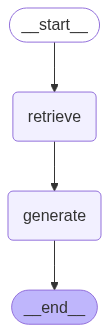

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### __Uso__

Ahora invocamos el grafo para generar una respuesta.

Invoke

In [ ]:
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

2025-07-16 14:48:22,646 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 200 OK"


--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'
Se encontraron 6 documentos
Documento más similar (score: 0.7195):
  Fuente: pdf_articulos_idearq\1148_Fortificacion_2021.pdf
  Contenido (inicio): 'acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpret...'

--- Ejecutando nodo: generate ---
Generando respuesta del LLM...


2025-07-16 14:48:43,308 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Context: [Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 2015 (Macintosh)', 'creationdate': '2021-06-21T17:24:32+02:00', 'source': 'pdf_articulos_idearq\\1148_Fortificacion_2021.pdf', 'file_path': 'pdf_articulos_idearq\\1148_Fortificacion_2021.pdf', 'total_pages': 26, 'format': 'PDF 1.4', 'title': '¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica de la muralla de cajones', 'author': 'Gutiérrez Soler, Luis María', 'subject': '', 'keywords': 'EDAD DEL HIERRO, PROTOHISTORIA MEDITERRÁNEA, GUADALQUIVIR, POLIORCÉTICA, SIERRA MORENA, SEGUNDA GUERRA PÚNICA', 'moddate': '2021-06-21T17:27:12+02:00', 'trapped': '', 'modDate': "D:20210621172712+02'00'", 'creationDate': "D:20210621172432+02'00'", 'start_index': 6526, '_id': '6893b244-a8ce-4757-b8cc-028655b23e30', '_collection_name': 'idearq'}, page_content='acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y \nFigura 1.\u2003 

Esta respuesta lleva a pensar que se necesita utilizar otro prompt.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

template = """
Eres un asistente experto en arqueología, historia e información geoespacial.
Tu tarea es responder a la pregunta del usuario basándote **única y exclusivamente** en el siguiente contexto proporcionado.

No utilices ningún conocimiento previo. Si la información no se encuentra en el contexto, responde exactamente: 
"La información solicitada no se encuentra en los documentos proporcionados."

Contexto:
{context}

Pregunta:
{question}

Respuesta concisa y útil:
"""

prompt = ChatPromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "Aquí irían los documentos sobre Giribaile...", "question": "¿Qué sabes sobre la fortificación ibérica de Giribaile?"}
).to_messages()

print("--- Estructura del nuevo prompt ---")
print(example_messages[0].content)


--- Estructura del nuevo prompt ---

Eres un asistente experto en arqueología, historia e información geoespacial.
Tu tarea es responder a la pregunta del usuario basándote **única y exclusivamente** en el siguiente contexto proporcionado.

No utilices ningún conocimiento previo. Si la información no se encuentra en el contexto, responde exactamente: 
"La información solicitada no se encuentra en los documentos proporcionados."

Contexto:
Aquí irían los documentos sobre Giribaile...

Pregunta:
¿Qué sabes sobre la fortificación ibérica de Giribaile?

Respuesta concisa y útil:



In [18]:
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'
Se encontraron 6 documentos
Documento más similar (score: 0.0000):
  Fuente: pdf_articulos_idearq\1000_oms_2017.pdf
  Contenido (inicio): 'Lab. reference
δ13
BP
Var.
Cal BC 2σ
References
Bonica IV2
Catalonia
Spain
6
Human bone
OxA-29639
19.19
6351
35
5466–5226
Present study
Bonica IV2
Catalonia
Spain
Human bone
Beta-384726
18.7
6390
30
5468–5316
Present study
Bonica IV2
Catalonia
Spain...'

--- Ejecutando nodo: generate ---


NotImplementedError: 

In [51]:
import json
# NUEVA MANERA
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})
print(json.dumps(result["answer"], indent=2))

--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'


2025-07-17 14:56:59,225 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 500 Internal Server Error"


UnexpectedResponse: Unexpected Response: 500 (Internal Server Error)
Raw response content:
b'{"status":{"error":"Service internal error: 1 of 1 read operations failed:\\n  Service internal error: task 181 panicked with message \\"called `Result::unwrap()` on an `Err` value: OutputTooSmall {  ...'